# Speech Signal Processing -  Assignment 3 

In [1]:
#Import required libraries 

import librosa
import sklearn
import matplotlib.pyplot as plt 
plt.style.use('seaborn-white')
import numpy as np 
import os 
import audioread
import csv 
from mpl_toolkits import mplot3d
from math import log
import librosa
import librosa.display
import essentia
import essentia, essentia.standard as ess
plt.rcParams['figure.figsize'] = (15,5)


# Scipy Specific Libraries.
import scipy 
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
from scipy.fftpack import ifft
from scipy.fft import fftshift


In [2]:
# Data Directory
datadir='./data/'

file1 = datadir+'niharika.wav'
file2 = datadir+'a_frame.wav'
file3 = datadir+'k_frame.wav'

print(file1)


./data/niharika.wav


# Helper Function : readFile()

In [3]:
#Reading the wav file and displaying stats. 
def readFile(fileName,flag=True,plot=True):
    Fs,data = wavfile.read(str(fileName))
    with audioread.audio_open(fileName) as f:
            time=f.duration
            if(flag):
                print('File Statistics ')
                print('File Name : ',fileName.strip('.wav'))
                print('Number of Channels :', f.channels)
                print('Sample Rate : ',str(f.samplerate)+ ' Hz')
                print('Time Duration: ', str(f.duration)+' secs')

    if(plot):
        times = np.arange(len(data))/float(Fs)
        # Make the plot
        plt.figure(figsize=(15,5))
        plt.plot(data)
        plt.xlabel('time (s)')
        plt.ylabel('amplitude')
        # You can set the format by changing the extension
        name=fileName.strip('.wav').strip(datadir)
        plt.savefig(str(name)+'_TA_plot.jpg', dpi=300, bbox_inches='tight')
        plt.title('Amplitude-Time Plot')
        plt.show()
        
    return(Fs,data,time)

File Statistics 
File Name :  /data/a_frame
Number of Channels : 2
Sample Rate :  48000 Hz
Time Duration:  0.017729166666666667 secs


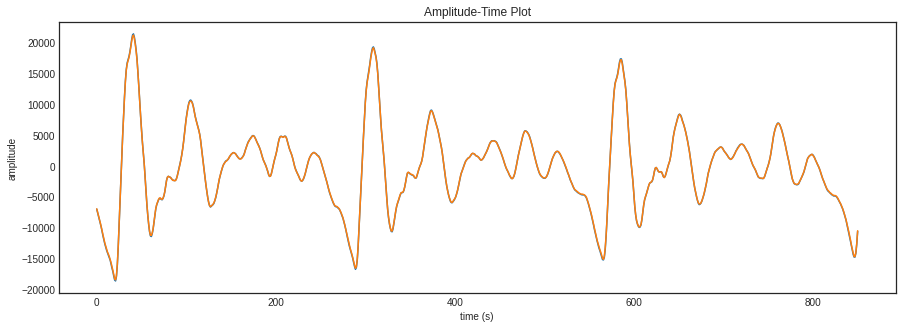

In [4]:
# Testing. 
Fs,data,t=readFile(file2,flag=True,plot=True)

# Short Term Fourier Transform : 2D & 3D Plots 

In [5]:
def stftPlot(fileName,nfft=512,hopLength=512,choice='2D',plot=True): 
    # Read the speech sample . 
    data,Fs= librosa.load(str(fileName))
    if(data.shape[0]==2):
        data=float(data[:,0])
    time =np.linspace(0,len(data),len(data))
    # Stft 
    X = librosa.stft(data, n_fft=nfft, hop_length=hopLength)
    X_mag=librosa.amplitude_to_db(abs(X))
    S = librosa.amplitude_to_db(abs(X_mag))
    
    if(choice=='2D'):
        plt.figure(figsize=(15, 5))
        librosa.display.specshow(X_mag,sr=Fs, hop_length=hopLength)
        plt.title('2D STFT Plot')
        plt.colorbar(format='%+2.0f dB')
        
    if(choice=='3D'):
        fig=plt.figure(figsize=(15, 5))
        ax = fig.gca(projection='3d')
        t,f,spec=signal.stft(data,Fs,nfft=512,nperseg=512)
        T,F = np.meshgrid(t,f)
        Sx=np.transpose(10.0*np.log10(abs(spec)))
        surf=ax.plot_surface(T,F,Sx,cmap='viridis')
        fig.colorbar(surf, format='%+2.0f dB')
        plt.show()
        
        
    

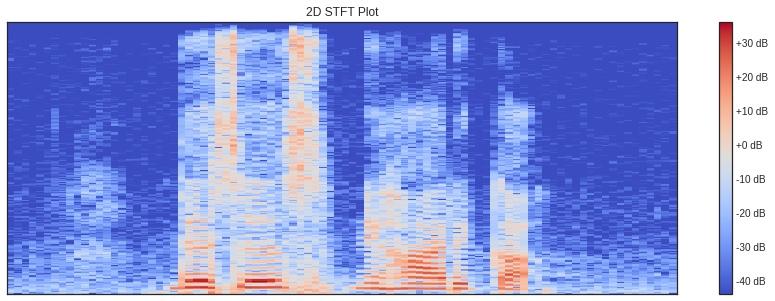

In [6]:
stftPlot(file1,choice='2D')

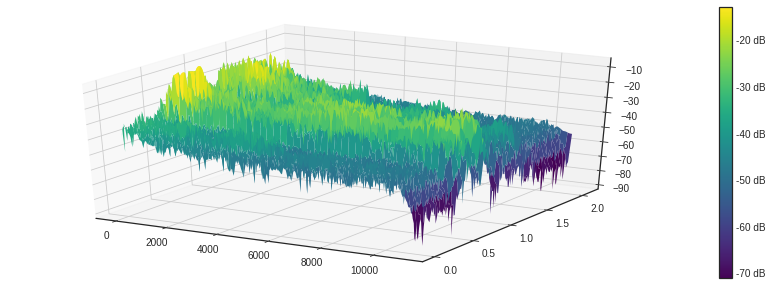

In [7]:
stftPlot(file1,choice='3D')

# Cepstral Analysis 

* Procedure for Cepstral Analysis : 
   * S(n) is the voiced frame considered , then x(n) is the windowed frame where - s(n) multiplied by a hamming window to get x(n).
   * |x(ω)| represents the spectrum of the windowed sequence x(n). The log|x(ω)| represents the log magnitude spectrum obtained by taking logarithm of the |x(ω)|
   * c(n) shows the computed spectrum for the voiced frame s(n). The obtained cepstrum contains vocal tract components which are linearly combined .
   * As the cepstrum is derived from the log magnitude of the linear spectrum, it is also symmetrical in the quefrency. 

In [8]:
def cepstralAnalysis(fileName,N=128,Lc=20,plot=False):
    Fs,data=wavfile.read(str(fileName))
    data=data[:, 0].flatten()
    # Apply Hamming Window.
    window=signal.hamming(N)
    filtered = np.convolve(data,window, 'same')/sum(window)
    # DFT 
    x_fft=np.fft.fft(filtered)
    # Log DFT
    x_fft_log=10*np.log10(abs(x_fft))
    # Inverse DFT - Cepstrum .
    x_cepstrum=np.fft.ifft(0.1*x_fft_log)
    # Liftered Signal 
    Nl=len(x_cepstrum)
    Lc=20
    low_lifter=[1 if(i>=0 and i<=Lc) else 0  for i in range(0,int(Nl),1)]
    x_liftered=10*np.log10(abs(np.fft.fft(np.multiply(low_lifter,x_cepstrum))))
    
    
    if(plot):
        fig, (ax_orig, ax_win, ax_filt,ax_dft,ax_log_dft,ax_cepstrum,ax_lift) = plt.subplots(7, 1, sharex=True,figsize=(50,25))
        plt.style.use('fivethirtyeight')
        
        #Speech Signal
        ax_orig.plot(data)
        ax_orig.set_title('Original pulse - s(n)')
        
        # Hamming Window
        ax_orig.margins(0, 0.1)
        ax_win.plot(window)
        ax_win.set_title('Filter impulse response - w(n)')
        
        # Filtered Signal
        ax_win.margins(0, 0.1)
        ax_filt.plot(filtered)
        ax_filt.set_title('Filtered signal - x(n)(Magnitude)')
        ax_filt.margins(0, 0.1)
        
        # DFT 
        ax_dft.margins(0, 0.1)
        t = np.arange(len(data))
        ax_dft.plot(abs(x_fft.real))
        ax_dft.set_title('DFT of x(n)- X(w)')
        
        #Log-DFT

        ax_log_dft.margins(0, 0.1)
        ax_log_dft.plot(abs(x_fft_log))
        ax_log_dft.set_title('Logarithmic Magnitude of X(w)')
        
        # IDFT Plot (Cepstrum)
        ax_cepstrum.margins(0, 0.1)
        ax_cepstrum.plot(abs(x_cepstrum))
        ax_cepstrum.set_title('IDFT Plot - Cepstrum')
        
        # Liftered Signal . 
        ax_lift.margins(0, 0.1)
        ax_lift.plot(abs(x_liftered))
        ax_lift.set_title('Liftered+DFT+Log Signal')
        
        # Plotting
        fig.tight_layout()
        fig.show()
        ax_orig.grid()
        ax_win.grid()
        ax_filt.grid()
        ax_dft.grid()
        ax_cepstrum.grid()
        ax_lift.grid()
        
        # Save as jpg file. 
        plt.savefig(str(fileName)+'_allplotsLog.jpg', dpi=300, bbox_inches='tight')



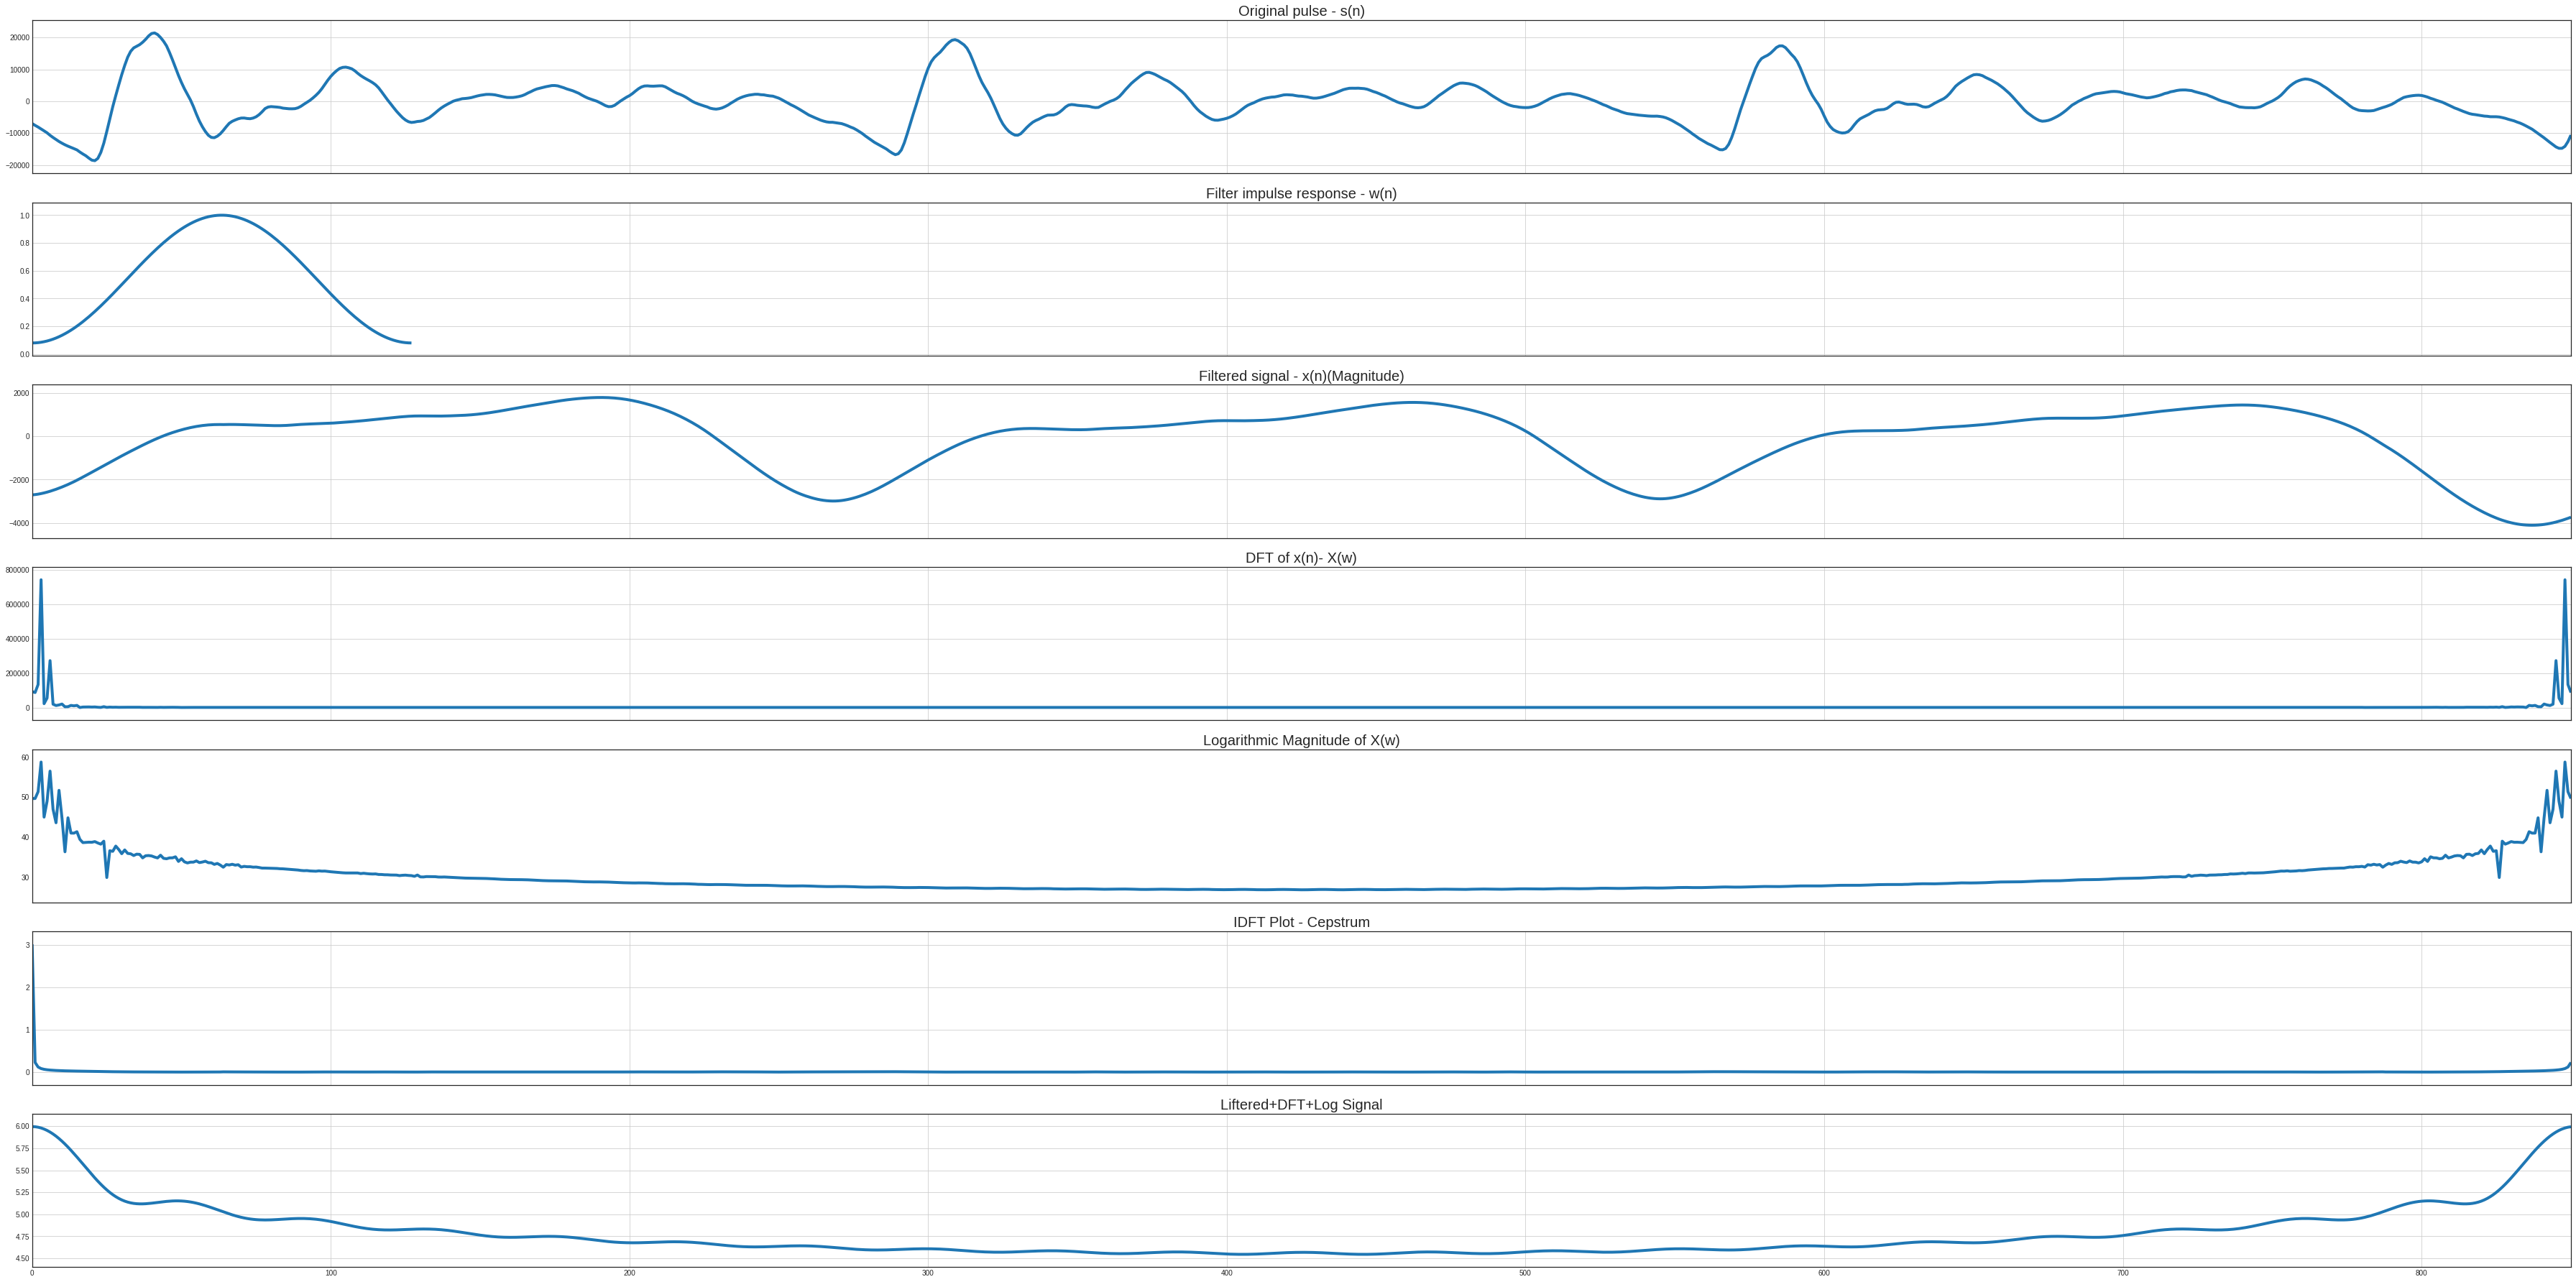

In [9]:
# Testing 
cepstralAnalysis(file2,N=128,plot=True)

# STFT Experiments : Unvoiced & Voiced Segments 

## Effect of Window on STFT  

In [10]:
def stftWindow(fileName,win='hann',N=256,plot=True):
    Fs,data=wavfile.read(str(fileName))
    data=data[:, 0].flatten()
    print(data.shape)
    freq,time,Sx = signal.stft(data,Fs, window=win, nperseg=256,nfft=N,return_onesided=True)
    # Lets plot the log Magnitude Specturum . 

    if(plot):
        fig=plt.figure(figsize=(15, 5))
        plt.style.use('fivethirtyeight')
        fscale=np.linspace(1/Fs,Fs/2000,len(list(Sx[:,0])))
        plt.plot(fscale,10.0*np.log10(abs(Sx[:,0])))
        plt.title('Frame STFT vs Frequency')
    
    

(629,)


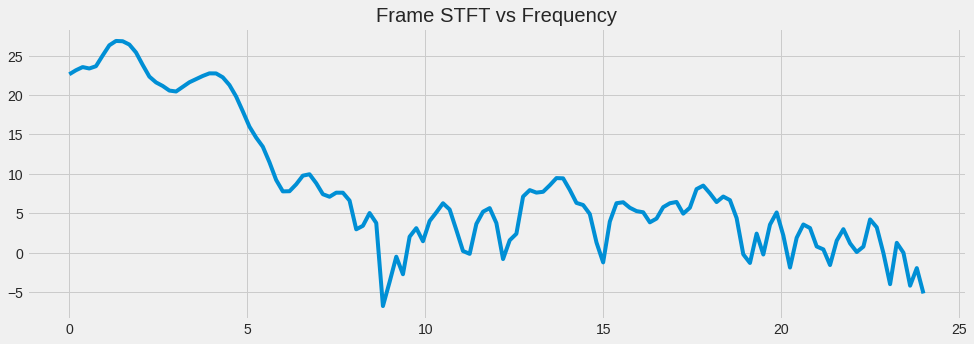

In [11]:
# Testing - STFT (Window)
stftWindow(file3,win='hamming',N=256,plot=True)

## Effect of N-point FFT  parameter on STFT  :

In [12]:
def stftNpoints(fileName,win='hann',Nfft=256,plot=True):
    Fs,data=wavfile.read(str(fileName))
    data=data[:, 0].flatten()
    print(data.shape)
    freq,time,Sx = signal.stft(data,Fs, window=win,nperseg=256,nfft=Nfft,return_onesided=True)
    # Lets plot the log Magnitude Specturum . 

    if(plot):
        fig=plt.figure(figsize=(15, 5))
        plt.style.use('fivethirtyeight')
        fscale=np.linspace(1/Fs,Fs/2000,len(list(Sx[:,0])))
        plt.plot(fscale,10.0*np.log10(abs(Sx[:,0])))
        plt.title('Frame STFT vs Frequency')
    

(629,)


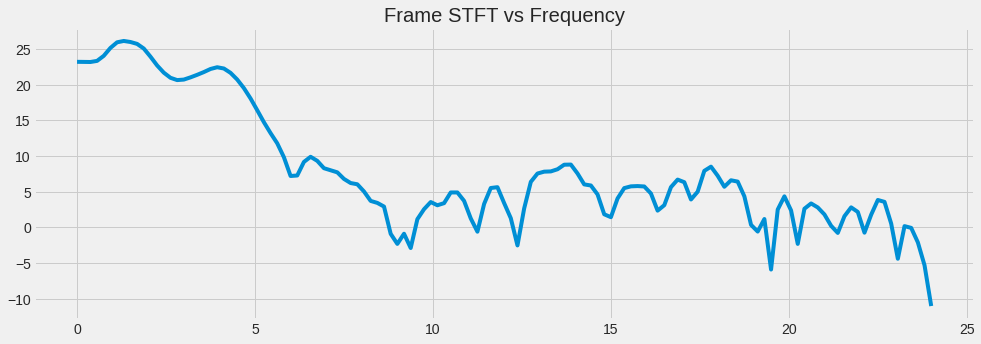

In [13]:
# Testing.
stftNpoints(file3,Nfft=256,plot=True)


## Effect of Window Length parameter on STFT  : 

In [14]:
def stftWindowLength(fileName,Nper=128,plot=True):
    Fs,data=wavfile.read(str(fileName))
    data=data[:, 0].flatten()
    print(data.shape)
    freq,time,Sx = signal.stft(data,Fs, window='hann',nperseg=Nper,nfft=Nper,return_onesided=True)
    # Lets plot the log Magnitude Specturum . 
    if(plot):
        fig=plt.figure(figsize=(15, 5))
        plt.style.use('fivethirtyeight')
        fscale=np.linspace(1/Fs,Fs/2000,len(list(Sx[:,0])))
        plt.plot(fscale,10.0*np.log10(abs(Sx[:,0])))
        plt.title('Frame STFT vs Frequency')
    

(629,)


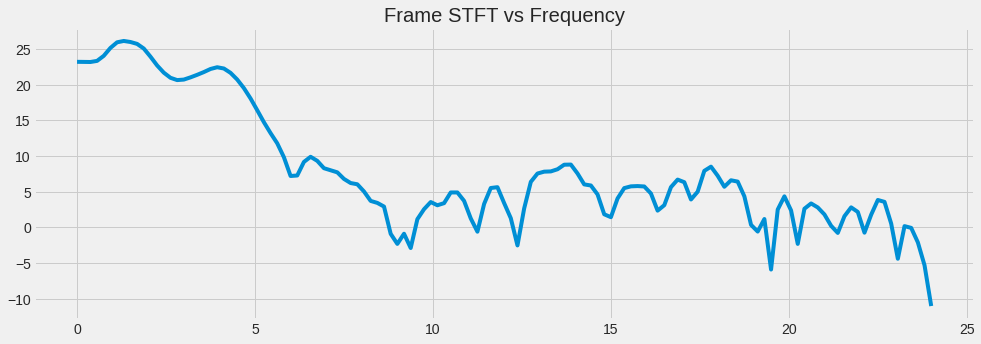

In [15]:
#Testing. 
stftWindowLength(file3,Nper=256,plot=True)

# Mel Frequency Cepstrum Coefficients  Analysis

In [16]:
def MFCCTime(fileName,plot=True):
    x, fs = librosa.load(fileName)
    mfccs = librosa.feature.mfcc(x, sr=fs)
    print('MFCC shape : ',mfccs.shape)
    if(plot):
        fig=plt.figure(figsize=[15,5])
        mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
        surf=librosa.display.specshow(mfccs, sr=fs, x_axis='time')
        plt.title('Normalised MFCC vs Time')
        plt.show()
        

MFCC shape :  (20, 90)


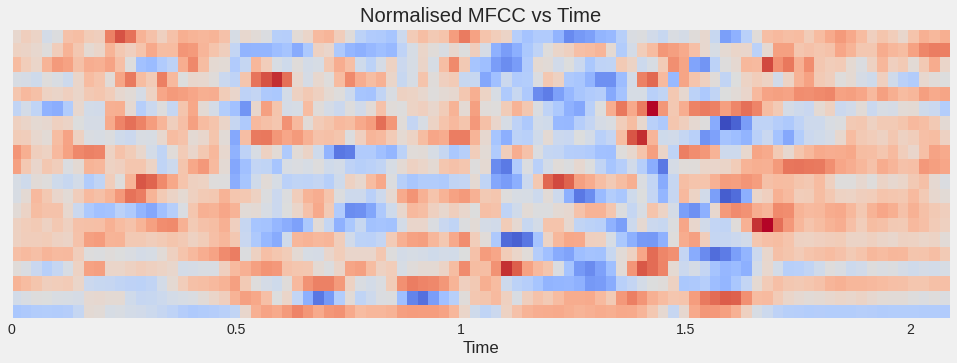

In [17]:
# Testing Part 
MFCCTime(file1,plot=True)

In [18]:
# MFCC-gram (i.e across the signal)
def MFCCFrame(fileName,Nc=13,frameSize=512,nperseg=256,plot=True):
    data,fs=librosa.load(fileName)
    hamming_window = ess.Windowing(type='hamming')
    spectrum = ess.Spectrum()  # we just want the magnitude spectrum
    mfcc = ess.MFCC(numberCoefficients=13)
    mfccs = np.array([mfcc(spectrum(hamming_window(frame)))[1]
                   for frame in ess.FrameGenerator(data, frameSize=frameSize, hopSize=nperseg)])
    mfccs = sklearn.preprocessing.scale(mfccs)
    plt.imshow(mfccs.T, origin='lower', aspect='auto', interpolation='nearest',cmap='viridis')
    plt.ylabel('MFCC Coefficient Index')
    plt.xlabel('Frame Index')
    print(mfccs.shape)

(180, 13)


/home/niharika.v/miniconda3/envs/ups/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/niharika.v/miniconda3/envs/ups/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


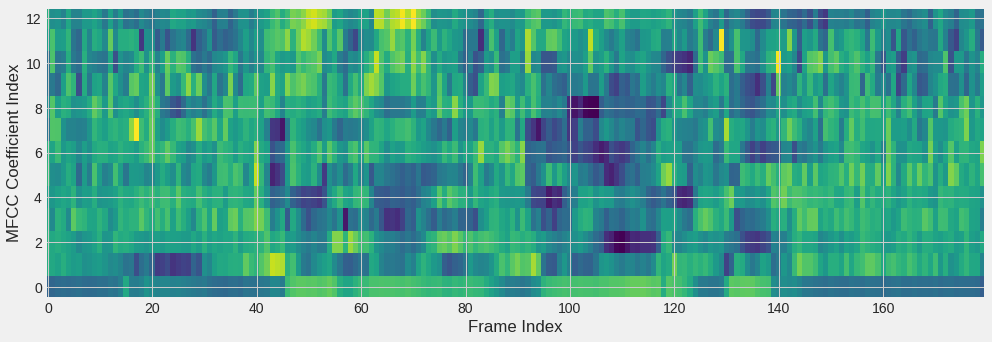

In [19]:
 MFCCFrame(file1)